In [22]:
import torch
import torchvision
from torchmetrics.classification import MulticlassAccuracy

import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

In [23]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
full_data_set = torchvision.datasets.ImageFolder('data/imagenet3/', transform = transformer)

In [24]:
print('Output targets are encoded as follows: {0}'.format(full_data_set.class_to_idx))

Output targets are encoded as follows: {'catacomb': 0, 'corgi': 1, 'eastern grey squirrel': 2, 'great blue heron': 3, 'hornet': 4, 'keyboard': 5, 'mute swan': 6, 'petunia': 7, 'tourist': 8, 'viper': 9}


In [25]:
print('The size of the dataset is: {0}'.format(len(full_data_set)))

The size of the dataset is: 9531


#### Creating Training, Validation and Testing dataset

In [26]:
train_data_set, val_data_set,test_data_set = torch.utils.data.random_split(full_data_set, [7000,1531,1000])

In [27]:
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=128, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data_set, batch_size=1531)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=1000)

In [28]:
if torch.backends.mps.is_available():
    DEVICE = torch.device(device='mps')
elif torch.cuda.is_available():
    DEVICE = torch.device(device='cuda')
else:
    DEVICE = torch.device(device='cpu')

### Learning Loop

In [29]:
loss_criteria = torch.nn.CrossEntropyLoss()
multiclass_accuracy  = MulticlassAccuracy(num_classes=len(full_data_set.classes)).to(device=DEVICE)

In [30]:
def one_epoch_train(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, 
                    loss_criterion: torch.nn, optim_alog: torch.optim) -> tuple:
    """Function that trains the model for one epoch.

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        tuple: Output tensor carrying predicted probability of each class.
    """
    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0
    for inputs, labels in data_loader_train:
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        
        # Enabling model training.
        model.train(True)
        
        #Setting gradients to zero to prevent gradient accumulation.
        optim_alog.zero_grad()
        
        # Forward pass.
        y_pred_prob = model(inputs)
        loss = loss_criterion(y_pred_prob, labels)
        
        batch_loss_train.append(loss.item())
        
        # Back Propagation
        loss.backward()
        
        # Updating weights
        optim_alog.step()
        
        # Calculating training accuracy.
        with torch.inference_mode():
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())
        batch_counter += 1
        
        del(inputs)
        del(labels)
        
    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter

In [31]:
def inference(model: torch.nn.Module, data_loader_val: torch.utils.data.DataLoader, loss_criterion: torch.nn) -> tuple:
    """Function that calculates test accuracy

    Args:
        model (torch.nn.Module): Pytorch model we want to make inference on.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.

    Returns:
        tuple: Tuple carrying Test loss and accuracy
    """
    
    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0
    
    for inputs, labels in data_loader_val:
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        
        # Disabiling model training.
        model.train(False)
        
        with torch.inference_mode():
            # Forward Pass
            y_pred_prob = model(inputs)
            
            # Calculating Loss
            loss = loss_criterion(y_pred_prob, labels)
            batch_loss_train.append(loss.item())
            
            # Calculating Accuracy
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())
            
        batch_counter += 1
        
        del inputs
        del labels
    
    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter
        

In [32]:
def training_loop(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, data_loader_val: torch.utils.data.DataLoader, 
                  epochs:int, loss_criterion: torch.nn, optim_alog: torch.optim)-> dict:
    """Function that trains the model for the given number of epochs

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        epochs (int): Count of EPOCHS
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        dict: A dictionary that carries the output metrics.
    """
    
    loss_train = []
    loss_val = []
    
    accuracy_train = []
    accuracy_val = []
    
    # Loop that iterates over each EPOCH
    for epoch in range(epochs):
        
        #Train the model for one EPOCH
        epoch_loss, epoch_accuracy = one_epoch_train(model, data_loader_train, loss_criterion, optim_alog)
        loss_train.append(epoch_loss)
        accuracy_train.append(epoch_accuracy)
        
        # Caluclating Testing results
        val_loss, val_accuracy = inference(model, data_loader_val, loss_criterion)
        loss_val.append(val_loss)
        accuracy_val.append(val_accuracy)
        
        if (epoch+1)%10 == 0:
            print('For Epoch {} We Train Loss:{}, Val Loss:{}, Train Accuracy:{}, Val Accuracy:{}'.format(epoch+1, epoch_loss,
                                                                                                        val_loss,
                                                                                                        epoch_accuracy,
                                                                                                        val_accuracy))
    return {'training_loss':loss_train, 'val_loss':loss_val, 'training_accuracy':accuracy_train, 'val_accuracy':accuracy_val}

In [33]:
def plot_metrics(epochs: int,metrics: dict) -> None:
    """Plot the graphs of Training and Testing Accuracy and Loss across Epoches

    Args:
        epochs (int): Number of Epochs
        metrics (dict): A dictionary containing Test and Training datasets' Loss and accuracy
    """
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(list(range(epochs)), metrics['training_loss'])
    plt.plot(list(range(epochs)), metrics['val_loss'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation loss across epochs')
    
    plt.subplot(1,2,2)
    plt.plot(list(range(epochs)), metrics['training_accuracy'])
    plt.plot(list(range(epochs)), metrics['val_accuracy'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation accuracy across epochs')
    
    plt.show()

In [43]:
def metrics_print(y_hat: torch.Tensor, labels: torch.Tensor) -> None:
    """Print Recall, Precision and F1 Score

    Args:
        y_hat (torch.Tensor): Predicted Probability
        labels (torch.Tensor): Obseved Labels
    """
    # Precision
    print("Precision (Micro):", precision_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='micro'))
    print("Precision (Macro):", precision_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='macro'))
    print("Precision (Weighted):", precision_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='weighted'))
    
    # Recall
    print("Recall (Micro):", recall_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='micro'))
    print("Recall (Macro):", recall_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='macro'))
    print("Recall (Weighted):", recall_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='weighted'))
    
    # F1 Score
    print("F1 Score (Micro):", f1_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='micro'))
    print("F1 Score (Macro):", f1_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='macro'))
    print("F1 Score (Weighted):", f1_score(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy(), average='weighted'))

### Model Building

#### Base Model

In [34]:
class AlexNet(torch.nn.Module):
    
    def __init__(self: 'AlexNet', input_size: int)-> None:
        """Function to initate the model layers

        Args:
            input_size (int): Input size of the image
        """
        super(AlexNet,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=10)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self: 'AlexNet', input_size: int, padding: int, stride: int, kernel_size: int) -> int:
        """Funtion that calculate the output convolution size

        Args:
            input_size (int): Size of the input
            padding (int): Padding size
            stride (int): Stride count
            kernel_size (int): Size of the Kernel

        Returns:
            int: Output convolution size.
        """
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self: 'AlexNet', x: torch.Tensor) -> torch.Tensor:
        """Function that performs the forward pass of the Neural Network

        Args:
            x (torch.Tensor): Input Tensor that carries that information about a batch of images

        Returns:
            torch.Tensor: Output tensor that carries the predicted probability of each class.
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [35]:
torch.manual_seed(18)
alx_model =AlexNet(64).to(device=DEVICE)
alx_model

AlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [36]:
EPOCHS = 160
optimizer = torch.optim.Adam(alx_model.parameters(), lr=4e-5)

In [37]:
output_metrics = training_loop(alx_model,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:2.006693855198947, Val Loss:2.0309183597564697, Train Accuracy:0.4372937034476887, Val Accuracy:0.412001371383667
For Epoch 20 We Train Loss:1.9246980905532838, Val Loss:1.9671311378479004, Train Accuracy:0.5274274999445135, Val Accuracy:0.4826161563396454
For Epoch 30 We Train Loss:1.8438927563753995, Val Loss:1.891076922416687, Train Accuracy:0.6095956759019332, Val Accuracy:0.5539233684539795
For Epoch 40 We Train Loss:1.7621869065544822, Val Loss:1.8389431238174438, Train Accuracy:0.6997179421511563, Val Accuracy:0.6131591200828552
For Epoch 50 We Train Loss:1.696195877682079, Val Loss:1.8385696411132812, Train Accuracy:0.7650113214146007, Val Accuracy:0.6166544556617737
For Epoch 60 We Train Loss:1.6563878709619695, Val Loss:1.7981135845184326, Train Accuracy:0.8111130638556047, Val Accuracy:0.6613256931304932
For Epoch 70 We Train Loss:1.6163071545687588, Val Loss:1.8075932264328003, Train Accuracy:0.8489248806780035, Val Accuracy:0.6474796533584595
For

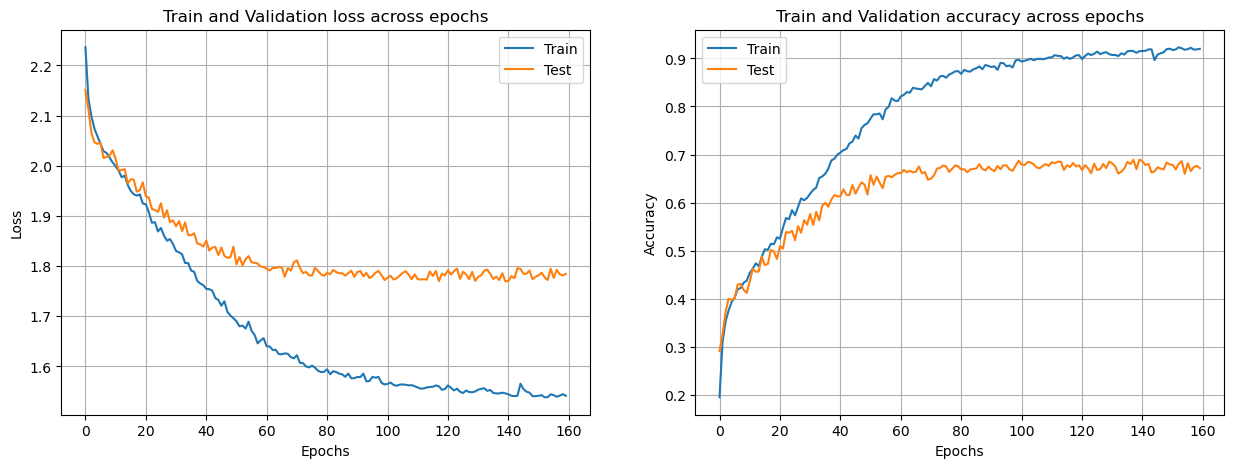

In [38]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [39]:
test_loss, test_accuracy = inference(alx_model, test_data_loader, loss_criteria)

In [40]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.6844322085380554


In [41]:
for inputs, labels in test_data_loader:
    inputs = inputs.to(device=DEVICE)
    labels = labels.to(device=DEVICE)
    alx_model.train(False)
    with torch.inference_mode():
        y_hat = alx_model(inputs)
        break

In [42]:
confusion_matrix(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy())

array([[ 77,   5,   1,   0,   1,   5,   1,   0,   1,   6],
       [  0,  71,   7,   4,   9,   0,   4,   3,   8,   4],
       [  1,   9,  57,   5,   8,   1,   6,   0,   5,   5],
       [  2,   5,   7,  66,   6,   0,   3,   3,   2,   5],
       [  2,   3,   3,   3,  79,   0,   0,   6,   2,   7],
       [  4,   6,   5,   2,   2,  35,   2,   1,   4,  10],
       [  1,   9,   4,   7,   8,   2,  68,   1,   4,   4],
       [  0,   1,   1,   0,   8,   0,   0, 109,   3,   1],
       [  0,   5,   1,   0,   3,   1,   0,   2,  81,   6],
       [  5,   2,   3,   5,  16,   3,   2,   1,   2,  52]])

In [44]:
metrics_print(y_hat, labels)

Precision (Micro): 0.695
Precision (Macro): 0.7014824120368244
Precision (Weighted): 0.7044983689048623
Recall (Micro): 0.695
Recall (Macro): 0.6844322090978747
Recall (Weighted): 0.695
F1 Score (Micro): 0.695
F1 Score (Macro): 0.6874062464815146
F1 Score (Weighted): 0.6948127762246904


In [55]:
del(alx_model)

#### Early Stopping

* We can see that after 80 EPOCHS the model is learning curve became plateau, it means that model is overfitting. So we will stop learning after 80 EPOCHS.

In [46]:
torch.manual_seed(69)
alx_model_es =AlexNet(64).to(device=DEVICE)
alx_model_es

AlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [47]:
EPOCHS = 80
optimizer = torch.optim.Adam(alx_model_es.parameters(), lr=4e-5)

In [48]:
output_metrics = training_loop(alx_model_es,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:2.0232622558420355, Val Loss:2.008971929550171, Train Accuracy:0.4235069702972065, Val Accuracy:0.43974870443344116
For Epoch 20 We Train Loss:1.929307629845359, Val Loss:1.973059892654419, Train Accuracy:0.5220389398661527, Val Accuracy:0.472602903842926
For Epoch 30 We Train Loss:1.845128642429005, Val Loss:1.8947606086730957, Train Accuracy:0.6167421145872636, Val Accuracy:0.5560501217842102
For Epoch 40 We Train Loss:1.757912026752125, Val Loss:1.8504637479782104, Train Accuracy:0.7074762777848678, Val Accuracy:0.6057858467102051
For Epoch 50 We Train Loss:1.6969237327575684, Val Loss:1.840742826461792, Train Accuracy:0.767239388552579, Val Accuracy:0.617272138595581
For Epoch 60 We Train Loss:1.6543291417035189, Val Loss:1.8235148191452026, Train Accuracy:0.8122515169056979, Val Accuracy:0.6417849659919739
For Epoch 70 We Train Loss:1.6298726385289972, Val Loss:1.8214348554611206, Train Accuracy:0.8331419045274908, Val Accuracy:0.6348211169242859
For Epo

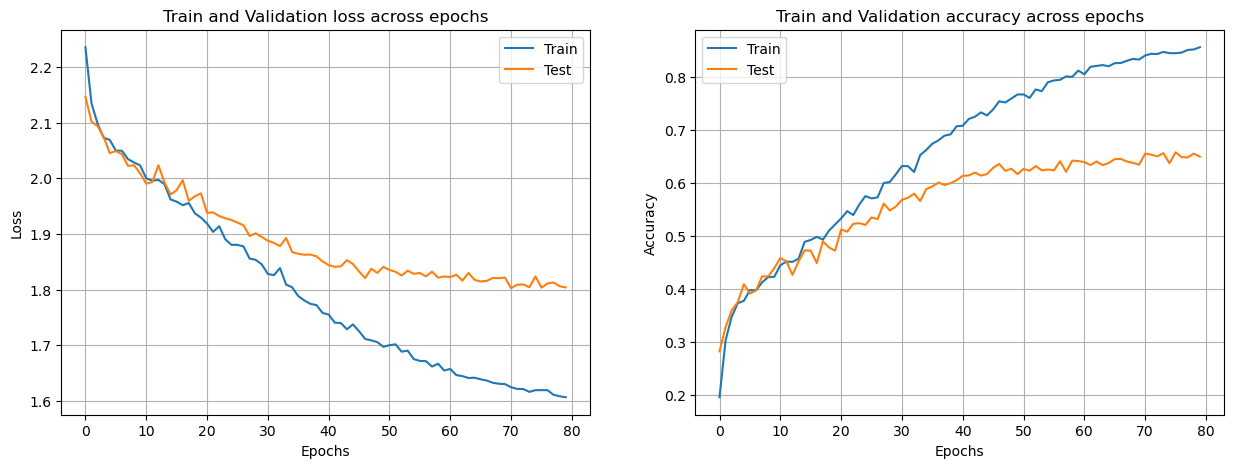

In [49]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [50]:
test_loss, test_accuracy = inference(alx_model_es, test_data_loader, loss_criteria)

In [51]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.653696596622467


In [52]:
for inputs, labels in test_data_loader:
    inputs = inputs.to(device=DEVICE)
    labels = labels.to(device=DEVICE)
    alx_model_es.train(False)
    with torch.inference_mode():
        y_hat = alx_model_es(inputs)
        break

In [53]:
confusion_matrix(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy())

array([[ 74,   7,   0,   1,   2,   3,   2,   0,   0,   8],
       [  3,  69,   4,   6,   7,   3,   9,   0,   4,   5],
       [  2,  13,  49,   4,   4,   3,  14,   0,   4,   4],
       [  1,   1,  11,  68,   0,   1,   9,   2,   1,   5],
       [  1,   7,   3,   8,  68,   1,   2,   6,   2,   7],
       [  9,   5,   3,   4,   0,  35,   3,   1,   3,   8],
       [  0,   5,   4,   9,   2,   4,  80,   0,   2,   2],
       [  0,   2,   1,   1,   7,   0,   0, 106,   4,   2],
       [  2,   9,   3,   2,   4,   0,   1,   0,  71,   7],
       [  6,   4,   4,   7,  16,   2,   4,   0,   3,  45]])

In [54]:
metrics_print(y_hat, labels)

Precision (Micro): 0.665
Precision (Macro): 0.6633767883793913
Precision (Weighted): 0.6691791660024947
Recall (Micro): 0.665
Recall (Macro): 0.6536966015656869
Recall (Weighted): 0.665
F1 Score (Micro): 0.665
F1 Score (Macro): 0.6558962717696082
F1 Score (Weighted): 0.6647998855367835


In [56]:
del(alx_model_es)

#### L2 Regularization

In [57]:
torch.manual_seed(69)
alx_model_l2 =AlexNet(64).to(device=DEVICE)
alx_model_l2

AlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [58]:
EPOCHS = 80
optimizer = torch.optim.Adam(alx_model_l2.parameters(), lr=4e-5, weight_decay=1e-3)

In [59]:
output_metrics = training_loop(alx_model_l2,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:2.0547656752846457, Val Loss:2.031728744506836, Train Accuracy:0.39168749343265186, Val Accuracy:0.4053875505924225
For Epoch 20 We Train Loss:1.9992123603820802, Val Loss:2.003476858139038, Train Accuracy:0.44824077161875636, Val Accuracy:0.4290706515312195
For Epoch 30 We Train Loss:1.9383369640870527, Val Loss:1.9558231830596924, Train Accuracy:0.5122255899689414, Val Accuracy:0.48297929763793945
For Epoch 40 We Train Loss:1.8875501090830022, Val Loss:1.9161077737808228, Train Accuracy:0.5642986124212092, Val Accuracy:0.5249142646789551
For Epoch 50 We Train Loss:1.831714077429338, Val Loss:1.896301031112671, Train Accuracy:0.623716629635204, Val Accuracy:0.5511278510093689
For Epoch 60 We Train Loss:1.798410084030845, Val Loss:1.8706001043319702, Train Accuracy:0.659494808587161, Val Accuracy:0.5757846236228943
For Epoch 70 We Train Loss:1.767536939274181, Val Loss:1.86154305934906, Train Accuracy:0.6880414670163935, Val Accuracy:0.5925246477127075
For Ep

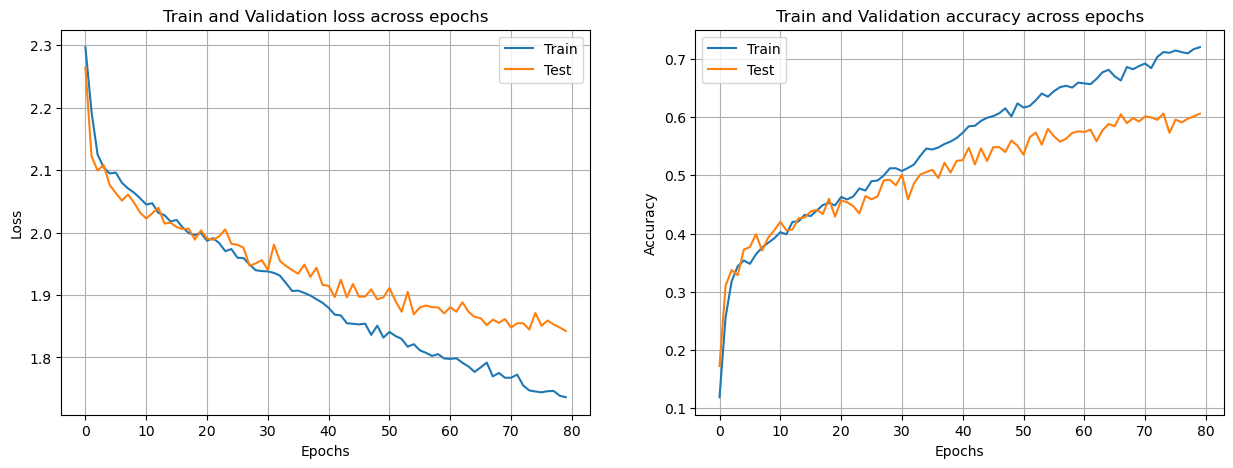

In [60]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [61]:
test_loss, test_accuracy = inference(alx_model_l2, test_data_loader, loss_criteria)

In [62]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.5909143090248108


In [63]:
for inputs, labels in test_data_loader:
    inputs = inputs.to(device=DEVICE)
    labels = labels.to(device=DEVICE)
    alx_model_l2.train(False)
    with torch.inference_mode():
        y_hat = alx_model_l2(inputs)
        break

In [64]:
confusion_matrix(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy())

array([[ 69,   8,   0,   1,   0,   5,   3,   0,   2,   9],
       [  1,  69,   5,   5,   0,   2,   8,   2,  12,   6],
       [  0,   7,  50,  10,   0,   3,  11,   0,   8,   8],
       [  2,   3,   6,  72,   0,   0,   8,   1,   2,   5],
       [  7,  18,   4,  13,   0,   2,   2,   4,  15,  40],
       [  8,   7,   1,   8,   0,  27,   5,   1,   4,  10],
       [  2,   7,   3,  14,   0,   1,  78,   0,   2,   1],
       [  0,   3,   1,   3,   0,   0,   6, 101,   8,   1],
       [  1,   4,   3,   6,   0,   3,   1,   0,  77,   4],
       [  5,   6,   2,  10,   0,   2,   3,   0,   6,  57]])

In [65]:
metrics_print(y_hat, labels)

Precision (Micro): 0.6
Precision (Macro): 0.5543789276713078
Precision (Weighted): 0.5596196630392143
Recall (Micro): 0.6
Recall (Macro): 0.590914310615338
Recall (Weighted): 0.6
F1 Score (Micro): 0.6
F1 Score (Macro): 0.5620336908993921
F1 Score (Weighted): 0.5700425761211709


In [66]:
del(alx_model_l2)

#### Drop Out

In [67]:
class AlexNetDO(torch.nn.Module):
    
    def __init__(self: 'AlexNetDO', input_size: int)-> None:
        """Function to initate the model layers

        Args:
            input_size (int): Input size of the image
        """
        super(AlexNetDO,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=10)
        
        self.dropout = torch.nn.Dropout(p=0.4)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self: 'AlexNetDO', input_size: int, padding: int, stride: int, kernel_size: int) -> int:
        """Funtion that calculate the output convolution size

        Args:
            input_size (int): Size of the input
            padding (int): Padding size
            stride (int): Stride count
            kernel_size (int): Size of the Kernel

        Returns:
            int: Output convolution size.
        """
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self: 'AlexNetDO', x: torch.Tensor) -> torch.Tensor:
        """Function that performs the forward pass of the Neural Network

        Args:
            x (torch.Tensor): Input Tensor that carries that information about a batch of images

        Returns:
            torch.Tensor: Output tensor that carries the predicted probability of each class.
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [68]:
torch.manual_seed(69)
alx_model_do =AlexNetDO(64).to(device=DEVICE)
alx_model_do

AlexNetDO(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (softmax): Softmax(dim=1)
)

In [69]:
EPOCHS = 160
optimizer = torch.optim.Adam(alx_model_do.parameters(), lr=4e-5, weight_decay=1e-3)

In [70]:
output_metrics = training_loop(alx_model_do,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:2.0777155789462003, Val Loss:2.0513479709625244, Train Accuracy:0.36617545214566316, Val Accuracy:0.38532623648643494
For Epoch 20 We Train Loss:2.0075603355060925, Val Loss:2.0199618339538574, Train Accuracy:0.4405841605229811, Val Accuracy:0.4223065972328186
For Epoch 30 We Train Loss:1.9537856297059493, Val Loss:1.9537928104400635, Train Accuracy:0.49271509105508976, Val Accuracy:0.4881058931350708
For Epoch 40 We Train Loss:1.8943915085359053, Val Loss:1.9191522598266602, Train Accuracy:0.5600766615434126, Val Accuracy:0.5300726890563965
For Epoch 50 We Train Loss:1.8496214064684782, Val Loss:1.891369342803955, Train Accuracy:0.6033711606805975, Val Accuracy:0.5555375814437866
For Epoch 60 We Train Loss:1.7958431460640647, Val Loss:1.873266339302063, Train Accuracy:0.6616394324736161, Val Accuracy:0.5713104605674744
For Epoch 70 We Train Loss:1.7859649246389215, Val Loss:1.8673985004425049, Train Accuracy:0.6686146465214816, Val Accuracy:0.583393394947052

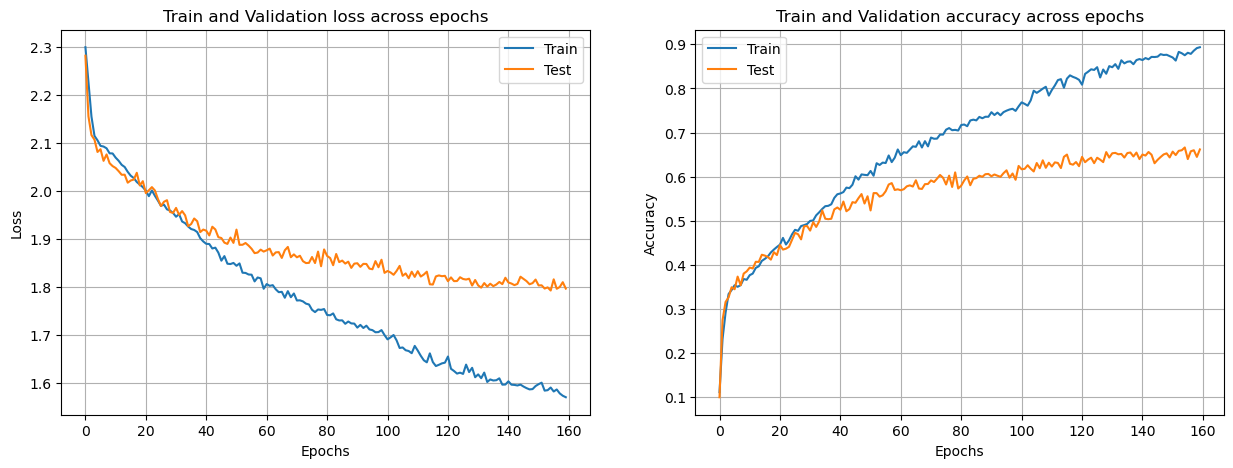

In [71]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [72]:
test_loss, test_accuracy = inference(alx_model_do, test_data_loader, loss_criteria)

In [73]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.6636635065078735


In [74]:
for inputs, labels in test_data_loader:
    inputs = inputs.to(device=DEVICE)
    labels = labels.to(device=DEVICE)
    alx_model_do.train(False)
    with torch.inference_mode():
        y_hat = alx_model_do(inputs)
        break

In [75]:
confusion_matrix(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy())

array([[ 77,   3,   0,   2,   4,   7,   2,   0,   0,   2],
       [  3,  61,  14,   3,  13,   2,   9,   0,   3,   2],
       [  0,   2,  66,   9,   7,   1,   6,   1,   3,   2],
       [  5,   0,   9,  69,   2,   1,   6,   2,   2,   3],
       [  4,   1,   4,   5,  70,   2,   1,   5,   2,  11],
       [  9,   6,   2,   5,   2,  32,   6,   2,   3,   4],
       [  2,   3,   4,  11,   2,   4,  78,   1,   2,   1],
       [  0,   0,   1,   0,   8,   0,   2, 108,   4,   0],
       [  1,   0,   4,   4,  11,   3,   2,   1,  67,   6],
       [  4,   1,   3,  13,  14,   4,   2,   0,   3,  47]])

In [76]:
metrics_print(y_hat, labels)

Precision (Micro): 0.675
Precision (Macro): 0.6749939467878157
Precision (Weighted): 0.6843532581609151
Recall (Micro): 0.675
Recall (Macro): 0.6636635043618861
Recall (Weighted): 0.675
F1 Score (Micro): 0.675
F1 Score (Macro): 0.6641857074319744
F1 Score (Weighted): 0.6745285798834628


In [77]:
del(alx_model_do)

#### Data Augmented Model

In [78]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
full_data_set = torchvision.datasets.ImageFolder('data/imagenet/', transform = transformer)

In [79]:
train_data_set, val_data_set,test_data_set = torch.utils.data.random_split(full_data_set, [5000,1553,1000])

In [80]:
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=128, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data_set, batch_size=1553)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=1000)

In [81]:
for image, label in train_data_loader:
    print(image.shape)
    break

torch.Size([128, 3, 64, 64])


In [82]:
torch.manual_seed(18)
alx_model_da =AlexNet(64).to(device=DEVICE)
alx_model_da

AlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [83]:
EPOCHS = 160
optimizer = torch.optim.Adam(alx_model_da.parameters(), lr=4e-5)

In [84]:
output_metrics = training_loop(alx_model_da,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:2.196142148971558, Val Loss:2.1840779781341553, Train Accuracy:0.21643773447722198, Val Accuracy:0.24485552310943604
For Epoch 20 We Train Loss:2.127784362435341, Val Loss:2.1297032833099365, Train Accuracy:0.2895078632980585, Val Accuracy:0.30585718154907227
For Epoch 30 We Train Loss:2.0861451506614683, Val Loss:2.1005001068115234, Train Accuracy:0.3314816802740097, Val Accuracy:0.3377104699611664
For Epoch 40 We Train Loss:2.048776203393936, Val Loss:2.06884503364563, Train Accuracy:0.384268144890666, Val Accuracy:0.36368852853775024
For Epoch 50 We Train Loss:2.0353916823863982, Val Loss:2.061807155609131, Train Accuracy:0.3878827512264252, Val Accuracy:0.37556684017181396
For Epoch 60 We Train Loss:2.0124310851097107, Val Loss:2.036975383758545, Train Accuracy:0.40996463373303416, Val Accuracy:0.4050513803958893
For Epoch 70 We Train Loss:1.9592195808887483, Val Loss:2.0285661220550537, Train Accuracy:0.46323844641447065, Val Accuracy:0.4097746014595032


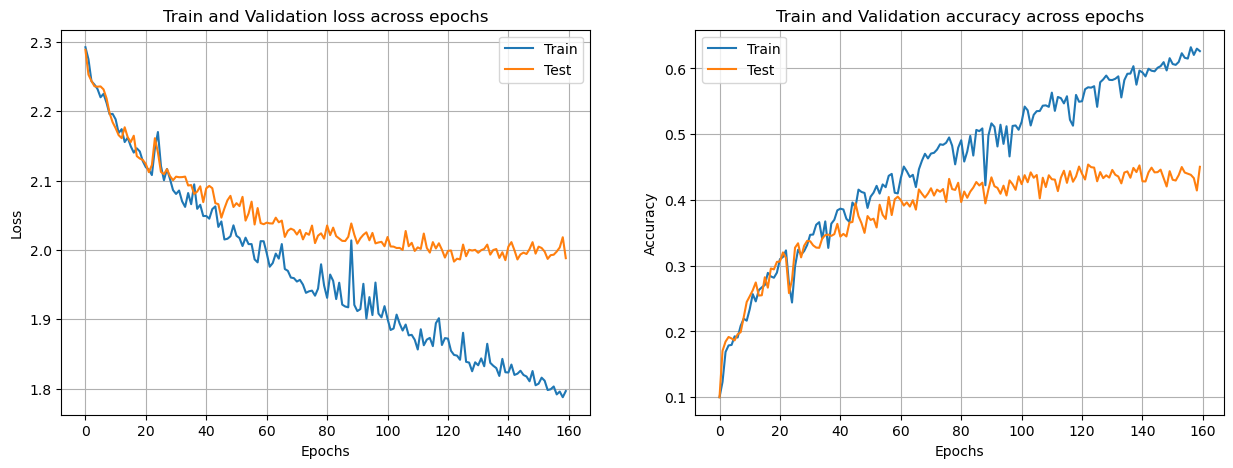

In [85]:
plot_metrics(epochs = EPOCHS,metrics = output_metrics)

In [90]:
test_loss, test_accuracy = inference(alx_model_da, test_data_loader, loss_criteria)

In [91]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.39887362718582153


In [92]:
for inputs, labels in test_data_loader:
    inputs = inputs.to(device=DEVICE)
    labels = labels.to(device=DEVICE)
    alx_model_da.train(False)
    with torch.inference_mode():
        y_hat = alx_model_da(inputs)
        break

In [93]:
confusion_matrix(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy())

array([[42, 10,  7,  0,  5, 15,  0,  5,  1, 16],
       [ 5, 57,  3,  0, 16, 10,  0, 11,  6, 18],
       [ 6,  5, 27,  0, 10, 28,  0,  3,  3,  2],
       [15,  3,  2,  0,  1, 29,  0,  1,  4, 16],
       [ 4, 15,  2,  0, 40,  8,  0,  4,  0,  5],
       [17,  4,  5,  0, 11, 58,  0,  6, 10, 16],
       [ 5, 27,  0,  0, 19,  4,  0,  3,  1,  3],
       [ 3, 12,  0,  0,  3,  0,  0, 67, 12,  6],
       [ 6,  6,  4,  0,  3, 10,  0, 12, 62,  9],
       [16,  3,  2,  0,  3, 16,  0,  4,  4, 88]])

In [94]:
metrics_print(y_hat, labels)

Precision (Micro): 0.441
Precision (Macro): 0.3630931519596367
Precision (Weighted): 0.3930992290416955
Recall (Micro): 0.441
Recall (Macro): 0.40102802231683243
Recall (Weighted): 0.441
F1 Score (Micro): 0.441
F1 Score (Macro): 0.3755204922704226
F1 Score (Weighted): 0.4104365863003546


In [95]:
del(alx_model_da)

## VGG Model

In [40]:
import torch
import torchvision
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import numpy as np

In [41]:
#  Maximum size of a tensor that can be split during a parallel operation on the GPU.
torch.backends.cuda.max_split_size = 512

In [6]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.Resize((112,112)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
full_data_set = torchvision.datasets.ImageFolder('data/imagenet3/', transform = transformer)

In [7]:
print('Output targets are encoded as follows: {0}'.format(full_data_set.class_to_idx))

Output targets are encoded as follows: {'catacomb': 0, 'corgi': 1, 'eastern grey squirrel': 2, 'great blue heron': 3, 'hornet': 4, 'keyboard': 5, 'mute swan': 6, 'petunia': 7, 'tourist': 8, 'viper': 9}


In [8]:
print('The size of the dataset is: {0}'.format(len(full_data_set)))

The size of the dataset is: 9531


#### Creating Training, Validation and Testing dataset

In [9]:
train_data_set, val_data_set,test_data_set = torch.utils.data.random_split(full_data_set, [7000,1531,1000])

In [10]:
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=128, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_data_set, batch_size=1531)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=1000)

In [11]:
if torch.backends.mps.is_available():
    DEVICE = torch.device(device='mps')
elif torch.cuda.is_available():
    DEVICE = torch.device(device='cuda')
else:
    DEVICE = torch.device(device='cpu')

### Mixed Precision Training Learning Loop

In [12]:
loss_criteria = torch.nn.CrossEntropyLoss()
multiclass_accuracy  = MulticlassAccuracy(num_classes=len(full_data_set.classes)).to(device=DEVICE)

In [13]:
scaler = torch.cuda.amp.GradScaler()

In [14]:
def one_epoch_train(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader,
                    loss_criterion: torch.nn, optim_alog: torch.optim) -> tuple:
    """Function that trains the model for one epoch.

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        tuple: Output tensor carrying predicted probability of each class.
    """
    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0
    for inputs, labels in data_loader_train:
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)

        # Enabling model training.
        model.train(True)

        #Setting gradients to zero to prevent gradient accumulation.
        optim_alog.zero_grad()

        # Forward pass.
        with torch.cuda.amp.autocast():
          y_pred_prob = model(inputs)
          loss = loss_criterion(y_pred_prob, labels)

        batch_loss_train.append(loss.item())

        # Back Propagation
        scaler.scale(loss).backward()

        # Updating weights
        scaler.step(optim_alog)
        scaler.update()

        # Calculating training accuracy.
        with torch.inference_mode():
          with torch.cuda.amp.autocast():
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())
        batch_counter += 1

        del(inputs)
        del(labels)

    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter

In [15]:
def inference(model: torch.nn.Module, data_loader_val: torch.utils.data.DataLoader, loss_criterion: torch.nn) -> tuple:
    """Function that calculates test accuracy

    Args:
        model (torch.nn.Module): Pytorch model we want to make inference on.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.

    Returns:
        tuple: Tuple carrying Test loss and accuracy
    """

    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0

    for inputs, labels in data_loader_val:
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)

        # Disabiling model training.
        model.train(False)

        with torch.inference_mode():
          with torch.cuda.amp.autocast():
            # Forward Pass
            y_pred_prob = model(inputs)

            # Calculating Loss
            loss = loss_criterion(y_pred_prob, labels)
            batch_loss_train.append(loss.item())

            # Calculating Accuracy
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())

        batch_counter += 1

        del inputs
        del labels

    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter


In [16]:
def training_loop(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, data_loader_val: torch.utils.data.DataLoader,
                  epochs:int, loss_criterion: torch.nn, optim_alog: torch.optim)-> dict:
    """Function that trains the model for the given number of epochs

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        epochs (int): Count of EPOCHS
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        dict: A dictionary that carries the output metrics.
    """

    loss_train = []
    loss_val = []

    accuracy_train = []
    accuracy_val = []

    # Loop that iterates over each EPOCH
    for epoch in range(epochs):

        #Train the model for one EPOCH
        epoch_loss, epoch_accuracy = one_epoch_train(model, data_loader_train, loss_criterion, optim_alog)
        loss_train.append(epoch_loss)
        accuracy_train.append(epoch_accuracy)

        # Caluclating Testing results
        val_loss, val_accuracy = inference(model, data_loader_val, loss_criterion)
        loss_val.append(val_loss)
        accuracy_val.append(val_accuracy)

        if (epoch+1)%10 == 0:
            print('For Epoch {} We Train Loss:{}, Val Loss:{}, Train Accuracy:{}, Val Accuracy:{}'.format(epoch+1, epoch_loss,
                                                                                                        val_loss,
                                                                                                        epoch_accuracy,
                                                                                                        val_accuracy))
    return {'training_loss':loss_train, 'val_loss':loss_val, 'training_accuracy':accuracy_train, 'val_accuracy':accuracy_val}

In [17]:
def plot_metrics(epochs: int,metrics: dict) -> None:
    """Plot the graphs of Training and Testing Accuracy and Loss across Epoches

    Args:
        epochs (int): Number of Epochs
        metrics (dict): A dictionary containing Test and Training datasets' Loss and accuracy
    """

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(list(range(epochs)), metrics['training_loss'])
    plt.plot(list(range(epochs)), metrics['val_loss'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation loss across epochs')

    plt.subplot(1,2,2)
    plt.plot(list(range(epochs)), metrics['training_accuracy'])
    plt.plot(list(range(epochs)), metrics['val_accuracy'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation accuracy across epochs')

    plt.show()

### Model Building

In [18]:
class VGG13(torch.nn.Module):

    def __init__(self, input_size):
        super(VGG13,self).__init__()

        self.max_pool = torch.nn.MaxPool2d(kernel_size=3, stride=3)

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])

        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        conv2_size = self._get_conv_output_size(conv1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])

        pool1_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)

        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        conv3_size = self._get_conv_output_size(pool1_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])

        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])

        pool2_size = self._get_conv_output_size(conv4_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)

        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        conv5_size = self._get_conv_output_size(pool2_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])

        self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        conv6_size = self._get_conv_output_size(conv5_size, self.conv6.padding[0], self.conv6.stride[0], self.conv6.kernel_size[0])

        pool3_size = self._get_conv_output_size(conv6_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)

        self.conv7 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=4)
        conv7_size = self._get_conv_output_size(pool3_size, self.conv7.padding[0], self.conv7.stride[0], self.conv7.kernel_size[0])

        self.conv8 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        conv8_size = self._get_conv_output_size(conv7_size, self.conv8.padding[0], self.conv8.stride[0], self.conv8.kernel_size[0])

        pool4_size = self._get_conv_output_size(conv8_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)

        self.conv9 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=4)
        conv9_size = self._get_conv_output_size(pool4_size, self.conv9.padding[0], self.conv9.stride[0], self.conv9.kernel_size[0])

        self.conv10 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        conv10_size = self._get_conv_output_size(conv9_size, self.conv10.padding[0], self.conv10.stride[0], self.conv10.kernel_size[0])

        pool5_size = self._get_conv_output_size(conv10_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)

        self.linear1 = torch.nn.Linear(in_features=self.conv10.out_channels*pool5_size*pool5_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=10)

        self.softmax = torch.nn.Softmax(dim=1)

    def _get_conv_output_size(self,input_size, padding, stride, kernel_size):
        return ((input_size+ (2* padding) - kernel_size)//stride)+1


    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool(x)

        x = torch.nn.functional.relu(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = self.max_pool(x)

        x = torch.nn.functional.relu(self.conv5(x))
        x = torch.nn.functional.relu(self.conv6(x))
        x = self.max_pool(x)

        x = torch.nn.functional.relu(self.conv7(x))
        x = torch.nn.functional.relu(self.conv8(x))
        x = self.max_pool(x)

        x = torch.nn.functional.relu(self.conv9(x))
        x = torch.nn.functional.relu(self.conv10(x))
        x = self.max_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.softmax(x)

        return x

In [19]:
torch.manual_seed(18)
vgg_model =VGG13(112).to(device=DEVICE)
vgg_model

VGG13(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [20]:
EPOCHS = 80
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=4e-5)

In [21]:
output_metrics = training_loop(vgg_model,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:2.100030365857211, Val Loss:2.113708734512329, Train Accuracy:0.3357310354709625, Val Accuracy:0.3270876407623291
For Epoch 20 We Train Loss:2.036554213003679, Val Loss:2.0564823150634766, Train Accuracy:0.405775342204354, Val Accuracy:0.3928096294403076
For Epoch 30 We Train Loss:1.9944773695685647, Val Loss:2.0064172744750977, Train Accuracy:0.4466451108455658, Val Accuracy:0.44563376903533936
For Epoch 40 We Train Loss:1.969996393810619, Val Loss:1.9920977354049683, Train Accuracy:0.47405777140097183, Val Accuracy:0.4561675786972046
For Epoch 50 We Train Loss:1.9460370107130571, Val Loss:1.9725844860076904, Train Accuracy:0.4979019668969241, Val Accuracy:0.4785770773887634
For Epoch 60 We Train Loss:1.9149556159973145, Val Loss:1.9515457153320312, Train Accuracy:0.530794885483655, Val Accuracy:0.4972192049026489
For Epoch 70 We Train Loss:1.879532796686346, Val Loss:1.9112645387649536, Train Accuracy:0.5631094775416634, Val Accuracy:0.5391907095909119
For 

In [28]:
output_metrics2 = training_loop(vgg_model,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:1.8373425592075694, Val Loss:1.9109820127487183, Train Accuracy:0.6111358312043277, Val Accuracy:0.5420700907707214
For Epoch 20 We Train Loss:1.8218996611508456, Val Loss:1.870118498802185, Train Accuracy:0.6310732028701088, Val Accuracy:0.582805871963501
For Epoch 30 We Train Loss:1.776807923750444, Val Loss:1.8464713096618652, Train Accuracy:0.6769458705728705, Val Accuracy:0.612431526184082
For Epoch 40 We Train Loss:1.7623381614685059, Val Loss:1.8287070989608765, Train Accuracy:0.6908330353823575, Val Accuracy:0.6232591867446899
For Epoch 50 We Train Loss:1.776018010486256, Val Loss:1.863929271697998, Train Accuracy:0.6811381806026805, Val Accuracy:0.5884376764297485
For Epoch 60 We Train Loss:1.7227545564824884, Val Loss:1.7960244417190552, Train Accuracy:0.7368241299282421, Val Accuracy:0.6637973785400391
For Epoch 70 We Train Loss:1.7193804675882514, Val Loss:1.7981189489364624, Train Accuracy:0.7385632493279197, Val Accuracy:0.6580777764320374
For E

In [34]:
output_metrics3 = training_loop(vgg_model,train_data_loader,val_data_loader,EPOCHS,loss_criteria,optimizer)

For Epoch 10 We Train Loss:1.6755529512058605, Val Loss:1.7772754430770874, Train Accuracy:0.7817937937649814, Val Accuracy:0.681474506855011
For Epoch 20 We Train Loss:1.7130531896244396, Val Loss:1.7750798463821411, Train Accuracy:0.7470330075784163, Val Accuracy:0.6804316639900208
For Epoch 30 We Train Loss:1.6732132586565884, Val Loss:1.7944157123565674, Train Accuracy:0.7856937278400767, Val Accuracy:0.6636090278625488
For Epoch 40 We Train Loss:1.6579589735377918, Val Loss:1.8051106929779053, Train Accuracy:0.8005152864889665, Val Accuracy:0.6556835174560547
For Epoch 50 We Train Loss:1.6444580728357487, Val Loss:1.7688806056976318, Train Accuracy:0.8116565877741033, Val Accuracy:0.6887233257293701
For Epoch 60 We Train Loss:1.6482202291488648, Val Loss:1.7766826152801514, Train Accuracy:0.8094424702904441, Val Accuracy:0.6871681213378906
For Epoch 70 We Train Loss:1.6499003930525347, Val Loss:1.7738276720046997, Train Accuracy:0.8061450806531039, Val Accuracy:0.6839274168014526


In [35]:
test_loss, test_accuracy = inference(vgg_model, test_data_loader, loss_criteria)

In [36]:
print('Test Accuracy is: {0}'.format(test_accuracy))

Test Accuracy is: 0.7189724445343018


In [37]:
torch.save(vgg_model.state_dict(), 'sadapala_assignment1_part_5.pickle')

In [38]:
temp_dict = {}

for key in output_metrics:
  temp_dict[key] = output_metrics[key]+output_metrics2[key]+output_metrics3[key]

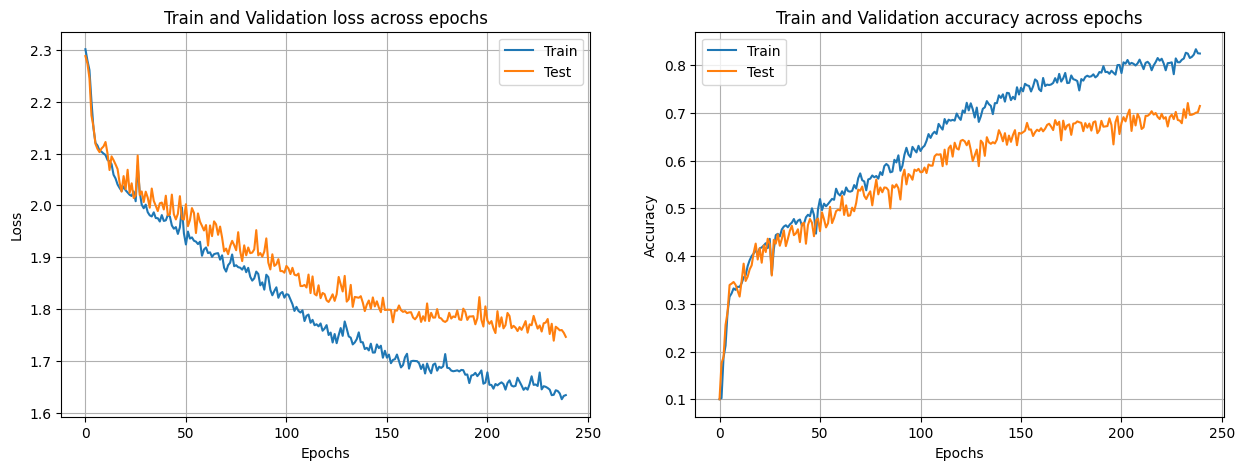

In [39]:
plot_metrics(epochs = EPOCHS*3,metrics = temp_dict)

In [43]:
for inputs, labels in test_data_loader:
    inputs = inputs.to(device=DEVICE)
    labels = labels.to(device=DEVICE)
    vgg_model.train(False)
    with torch.inference_mode():
        y_hat = vgg_model(inputs)
        break

In [44]:
confusion_matrix(labels.to(device='cpu').numpy(),torch.argmax(y_hat, axis=1).to(device='cpu').numpy())

array([[70,  0,  2,  1,  3,  0,  0,  0,  0, 11],
       [ 2, 67,  8,  4,  5,  0,  2,  0,  6,  3],
       [ 3,  4, 97,  2,  2,  3,  4,  0,  1, 10],
       [ 0,  2,  3, 70,  5,  2, 12,  0,  3, 14],
       [ 1,  2,  3,  1, 62,  1,  3,  3,  4, 14],
       [11,  4,  1,  3,  7, 39,  2,  1,  3,  2],
       [ 1,  1,  9,  5,  6,  2, 78,  0,  3,  1],
       [ 0,  2,  0,  2,  5,  0,  1, 87,  1,  0],
       [ 1, 10,  2,  0,  5,  3,  7,  3, 79,  1],
       [ 8,  4,  6,  2, 11,  1,  0,  1,  1, 63]])

In [45]:
metrics_print(y_hat, labels)

Precision (Micro): 0.712
Precision (Macro): 0.7204042171646307
Precision (Weighted): 0.722215801779488
Recall (Micro): 0.712
Recall (Macro): 0.707441270097221
Recall (Weighted): 0.712
F1 Score (Micro): 0.712
F1 Score (Macro): 0.7096213768057178
F1 Score (Weighted): 0.7133206751006701


### References:

* Part 4 and Part 5 Architecture and Helper Functions are based CSE 574 Machine Learning Assignment 2 by Shri Harsha Adapala Thirumala.
* Numpy: https://numpy.org/doc/stable/
* Pandas: https://pandas.pydata.org/docs/reference/index.html
* Matplotlib: https://matplotlib.org/stable/api/index.html
* Seaborn: https://seaborn.pydata.org/api.html
* PyTorch: https://pytorch.org/docs/stable/index.html
* TorchVision: https://pytorch.org/vision/stable/index.html
* TorchMetrics: https://torchmetrics.readthedocs.io/en/stable/
* AlexNet: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
* VGG-13: https://arxiv.org/pdf/1409.1556.pdf
* Earlystopping: https://www.educative.io/answers/what-is-early-stopping
* Mixed Precision Training in Pytorch: https://pytorch.org/docs/stable/notes/amp_examples.html
